### **Function testing**
just to test functioning of some coding - you can skip this part

In [1]:
import numpy as np

batch = [(1, 2), (6, 5), (5, 9)]

for i in zip(*batch):
    print(i)
    
res = map(np.stack, zip(*batch))

for id, i in enumerate(res):
    print(id, end=": ")
    for j in i:
        print(i, end=" ")
    print()
    
del res, batch

(1, 6, 5)
(2, 5, 9)
0: [1 6 5] [1 6 5] [1 6 5] 
1: [2 5 9] [2 5 9] [2 5 9] 


In [2]:
A = np.random.rand(2, 3, 2)
A = A.reshape(1,-1)
print(A.shape)
print(A)

(1, 12)
[[0.30336463 0.63006889 0.1497885  0.782219   0.00800374 0.44044373
  0.22829928 0.17337563 0.59634401 0.74992297 0.48982611 0.90902297]]


### **Training model using DDPG technique with Continous enviroment**

<h5><b>Initializing important library and set random seed for stable hyperparameters adjustment</b></h5>

In [1]:
import sys
# For Unix base OS
sys.path.append('../stableBL/')
# For Windows OS
# sys.path.append('..\stableBL\')
from ddpg import Actor, Critic, ReplayBuffer, DDPGAgent
import torch
import numpy as np
import gymnasium as gym

In [7]:
# Using deterministic random to ensure that initial weights will be the same
torch.manual_seed(42)
print("finish")

finish


<h5><b>Create enviroment system</b></h5>

In [5]:
# Crate enviroment using gynasium
env = gym.make('Hopper-v4')
# Get the state of the object inside environment
state_dim = env.observation_space.shape[0]
# Get possible action of the object to interact with enviroment
action_dim = env.action_space.shape[0]
# In the case of "Continuous" enviroment, we should get max action to determine range of action value
max_action = float(env.action_space.high[0])

print(state_dim, action_dim, max_action)

11 3 1.0


<h5><b>Agent architecture, Training, and Hyperparameters tuning</b></h5>

The idea behind ***DDPG (Deep Deterministic Policy Gradient Optimization)*** consists of **4 keypoints** <br>

**1. Deterministic Policy (Actor):** <br>
This model <u>maps the input state into spacific value under action space</u> of the environment, unlike Actor-Critic or PGO model with using the probability distribution to select the action value for each input state. <br> 

**2. Off-Policy learning:** <br>
This technique allows DDPG model to <u>learn past states anlong with new states</u> by storing every action inside <u>replay_buffer</u> (Can be either Dque or Array), then sample those states from replay_buffer and feed to learning algorithm for parameters optimization. <br>

**3. Noise Exploration:** <br>
This noise will be added to action value (output from Actor) in order to make model explore to more scenario. <br>

**4. Q_value optimization and Bellman Error (Critic):** <br>
<u>Actor model</u>: will be updated by **-1 * Q_value** (q is output from critic) with the purpose to maximize Q_value <br>
<u>Critic model</u>: Q_vaule measures how good of the action is when reacting to the current state of environment. <br>

It defines as this Bellman euqation

<p><b>Q(s,a)=E_r,s′[r+γQ(s′,π(s′))]</b></p>

**r** is reward<br>
**s'** is next state<br>
**γ** is how much greedy of Q_value | 0 means very greedy, 1 means not interest in current reward <br>

**DDPG use above equation to define Q_traget**<br>

Then DDPG update critic model parameters by performing gradient optimiztion of the function <u><b>MESLoss(Q_value, Q_traget)</b></u> <br>
##Note Q_value is the output of Critic model in DDPG context <br>

The effect of hyperparameters
1. gamma [0, 1]: Define how greedy of the model | 0 = greedy, 1 = not greedy
2. tau [0.001, 0.01]: Determine how soft and hard in updating Actor / Critic model | Higher means more hard
3. theta [0.1, 0.3]: How quick the noise will decay allows more stability in training
4. sigma [0.2, 0.3]: Amplitude of Noise which allows more exploration

In [6]:
agent = DDPGAgent(state_dim, action_dim, 1, sigma=0.2, actor_lr=1e-4, critic_lr=1e-3)

In [1]:
episodes = 2000
mxstep = 500
batchsize = 64
mx_reward = -1e9
rewards = []

for ep in range(1, episodes+1):
    episode_reward = 0
    state = env.reset()
    agent.reset_noise()
    for i in range(mxstep):
        if type(state) == tuple:
            state = state[0]
            action = agent.select_action(np.array(state))
        else:
            action = agent.select_action(np.array(state))
        next_state, reward, done, _, _ = env.step(action)
        agent.replay_buffer.add(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        
        if agent.replay_buffer.size() > batchsize:
            # print(ep)
            agent.train(batchsize)
            # agent.replay_buffer.reset()
        
        if int(done):
            break
    
    rewards.append(episode_reward)
    if episode_reward > mx_reward:
        mx_reward = episode_reward
        agent.save("best", "./")
    
    if ep % 100 == 0:
        print(f"at {ep}: total reward is {np.array(rewards[ep-100:ep]).mean()}")

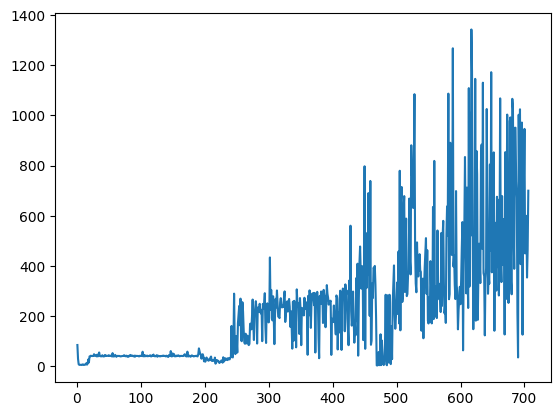

In [8]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(1, len(rewards), len(rewards), dtype=np.int64), rewards)
plt.show()

In [10]:
env = gym.make('Hopper-v4', render_mode="human")

agent.load("best", "./")

def play_env(episode = 5):
    for ep in range(episode):
        state, _ = env.reset()
        done = False
        sum_reward = 0
        while not done:
            env.render()
            action = agent.select_action(np.array(state))
            state, reward, done, _, _ = env.step(action)
            sum_reward += reward
        print(f"Episode: {ep+1}, sum reward: {sum_reward}")
        
play_env()
env.close()

Episode: 1, sum reward: 310.6449110387538
Episode: 2, sum reward: 1158.6170989051022
Episode: 3, sum reward: 465.8575486497815
Episode: 4, sum reward: 637.1207863793
Episode: 5, sum reward: 578.7567945509339


In [ ]:
env.close()